In [1]:
# ! git clone https://github.com/vinthony/deep-blind-watermark-removal.git # get code from github
# ! gdown https://drive.google.com/uc?id=1KpSJ6385CHN6WlAINqB3CYrJdleQTJBc # get pretrained model
# ! mv 27kpng_model_best.pth.tar deep-blind-watermark-removal/

fatal: destination path 'deep-blind-watermark-removal' already exists and is not an empty directory.
Downloading...
From (original): https://drive.google.com/uc?id=1KpSJ6385CHN6WlAINqB3CYrJdleQTJBc
From (redirected): https://drive.google.com/uc?id=1KpSJ6385CHN6WlAINqB3CYrJdleQTJBc&confirm=t&uuid=e73abf2c-eb3f-48d0-8411-8028ec6d2f5a
To: /app/notebooks/27kpng_model_best.pth.tar
100%|█████████████████████████████████████████| 131M/131M [00:00<00:00, 138MB/s]


In [1]:
import torch

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Available GPUs: {device_count}")
    
    for i in range(device_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("No CUDA devices found.")

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print('Using: ', device)

Available GPUs: 4
GPU 0: NVIDIA A100 80GB PCIe
GPU 1: NVIDIA A100 80GB PCIe
GPU 2: NVIDIA A100 80GB PCIe
GPU 3: NVIDIA A100 80GB PCIe
Using:  cuda:3


In [2]:
import sys

SPLITNET_DIR = 'deep-blind-watermark-removal'

sys.path.append(SPLITNET_DIR)
sys.path.insert(0, SPLITNET_DIR)

from scripts.utils.imutils import im_to_numpy
import scripts.models as models
import scripts.datasets as datasets

In [3]:
resume_path = f'{SPLITNET_DIR}/27kpng_model_best.pth.tar' # path of pretrained model

In [4]:
from lib.models.inference_wrapper import InferenceWrapper


model = models.__dict__['vvv4n']().to(device)
model.load_state_dict(torch.load(resume_path)['state_dict'])
model.eval()

model = InferenceWrapper(model)
print('loaded_model')

/opt/conda/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_28894/2037124889.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_

loaded_model


In [91]:
import os
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import glob

def denormalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """Denormalize a tensor image with mean and std"""
    # Clone to avoid modifying original
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization: (t * s) + m
    return tensor.clamp_(0, 1)  # Clamp to valid range
    

input_dir = '/data/dwh_selected_images'  
output_dir = '/data/outputs/splitnet_processed_images'

os.makedirs(output_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust size as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

image_paths = glob.glob(os.path.join(input_dir, '*.jpg'))    

In [92]:
import random
import matplotlib.pyplot as plt
import numpy as np

def run_on_one_image(image):
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        I_hat, _ = model(denormalize(image_tensor))
    
    output_image = I_hat.squeeze(0).cpu()
    
    def tensor_to_display(tensor):
        """Convert a tensor image to displayable numpy array"""
        if len(tensor.shape) == 3:
            tensor = tensor.permute(1, 2, 0)  # CHW to HWC
        return tensor.numpy()
    
    processed_input = tensor_to_display(denormalize(image_tensor).squeeze(0).cpu())
    result_output = tensor_to_display(output_image)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(processed_input)
    plt.title("Processed Input")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(result_output)
    plt.title("Model Output")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0018051341..1.7366924].


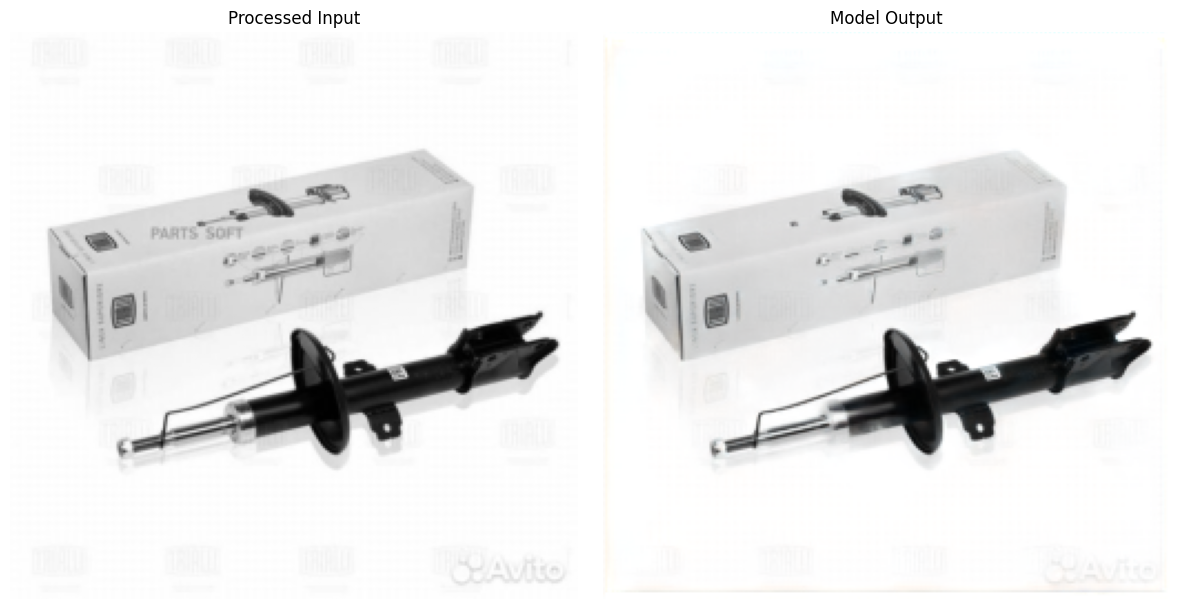

In [93]:
random_image_path = random.choice(image_paths)
image = Image.open(random_image_path).convert('RGB')

run_on_one_image(image)

In [22]:
!pip install lpips --quiet
from tqdm import tqdm
from lpips import LPIPS
from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim

def evaluate_model(model, dataloader, device):
    psnr_values = []
    ssim_values = []
    lpips_values = []
    f1_values = []
    iou_values = []
    lpips_model = LPIPS(net='alex').to(device)

    with torch.no_grad():
        for batch in tqdm(dataloader):
            J = batch['image'].to(device)
            I = batch['target'].to(device)
            M = batch['mask'].to(device)
            
            # Forward pass
            I_hat, M_hat  = model(J)

            # Process each item in the batch individually
            batch_size = J.shape[0]
            for i in range(batch_size):
                # Get individual items
                img_pred = I_hat[i].unsqueeze(0).clamp(0, 1)
                img_gt = I[i].unsqueeze(0).clamp(0, 1)
                mask_pred = M_hat[i] # [1, H, W]
                mask_gt = M[i].unsqueeze(0).squeeze(1)  # [1, H, W]
                
                # Convert mask probabilities to binary
                mask_pred_binary = (mask_pred > 0.5).float()
                
                # Calculate image metrics
                current_psnr = psnr(img_pred, img_gt)
                current_ssim = ssim(img_pred, img_gt)
                current_lpips = lpips_model(img_pred, img_gt)
                
                # Calculate mask metrics
                intersection = (mask_pred_binary * mask_gt).sum()
                union = (mask_pred_binary + mask_gt).clamp(0, 1).sum()
                
                current_iou = intersection / union
                current_f1 = (2 * intersection) / (mask_pred_binary.sum() + mask_gt.sum())
                
                # Store metrics
                psnr_values.append(current_psnr.item())
                ssim_values.append(current_ssim.item())
                lpips_values.append(current_lpips.item())
                f1_values.append(current_f1.item())
                iou_values.append(current_iou.item())
    
    # Calculate averages
    metrics = {
        'PSNR': sum(psnr_values) / len(psnr_values),
        'SSIM': sum(ssim_values) / len(ssim_values),
        'LPIPS': sum(lpips_values) / len(lpips_values),
        'F1': sum(f1_values) / len(f1_values),
        'IOU': sum(iou_values) / len(iou_values),
    }
    
    return metrics

In [23]:
from lib.dataset.dataset import get_dataloaders

train_loader, val_loader = get_dataloaders(data_root='../data/27kpng')

metrics = evaluate_model(model, val_loader, device)
print(metrics)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


100%|██████████| 507/507 [02:00<00:00,  4.22it/s]

{'PSNR': 41.24639968923862, 'SSIM': 0.9917345922748355, 'LPIPS': 0.009385168653840457, 'F1': 0.8160506599582906, 'IOU': 0.7266289818038528}


In [11]:
import torch
import torch.nn.functional as F
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

def compute_metrics_torch(original, improved):
    """
    Compute PSNR and SSIM for PyTorch tensors (range [0, 1], unclamped).
    
    Args:
        original (torch.Tensor): Ground truth image, shape [B, C, H, W].
        improved (torch.Tensor): Predicted image, shape [B, C, H, W].
    
    Returns:
        psnr (float): PSNR in dB.
        ssim (float): SSIM index.
    """
    # Clamp improved image to [0, 1] (SSIM/PSNR assume valid pixel range)
    improved_clamped = improved.clamp(0, 1)
    
    # Compute PSNR (scaled to 0-255)
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    psnr = psnr_metric(improved_clamped, original)
    
    # Compute SSIM
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    ssim = ssim_metric(improved_clamped, original)
    
    return psnr, ssim

In [18]:
!pip install matplotlib --quiet
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim

def denormalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """Denormalize a tensor image with mean and std"""
    # Clone to avoid modifying original
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization: (t * s) + m

    return tensor
    # return tensor.clamp_(0, 1)  # Clamp to valid range

def visualize_random_samples(model, dataloader, device, num_samples=5):
    """
    Enhanced visualization with clear mask error display
    """
    dataset = dataloader.dataset
    sample_indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in sample_indices]

    # Create figure with more columns for better mask comparison
    fig, axs = plt.subplots(num_samples, 5, figsize=(25, 5*num_samples))
    if num_samples == 1:
        axs = axs.reshape(1, -1)

    with torch.no_grad():
        for i, sample in enumerate(samples):
            J = sample['image'].unsqueeze(0).to(device)
            I = sample['target'].unsqueeze(0).to(device)
            M = sample['mask'].unsqueeze(0).to(device)

            # Forward pass
            I_hat, M_hat = model(J)
            current_psnr, current_ssim = compute_metrics_torch(I_hat, I)

            
            pred_mask_probs = M_hat.squeeze(1)  # Now shape [B, H, W]

            
            # Convert to numpy
            watermarked = J.squeeze().permute(1, 2, 0).cpu().numpy()
            predicted = I_hat.clamp(0,1).squeeze().permute(1, 2, 0).cpu().numpy()
            ground_truth = I.squeeze().permute(1, 2, 0).cpu().numpy()
            
            true_mask = M.squeeze().cpu().numpy()  # (H,W)
            pred_mask = pred_mask_probs.squeeze().cpu().numpy()  # (H,W)
            pred_mask_binary = (pred_mask > 0.5).astype(np.float32)

            # Calculate error regions
            correct_positives = (pred_mask_binary * true_mask)  # True positives
            false_positives = np.clip(pred_mask_binary - true_mask, 0, 1)  # FP
            false_negatives = np.clip(true_mask - pred_mask_binary, 0, 1)  # FN


            # Compute metrics
            # current_ssim = compute_ssim(predicted, ground_truth)
            
            intersection = np.sum(pred_mask_binary * true_mask)
            union = np.sum(np.clip(pred_mask_binary + true_mask, 0, 1))
            current_iou = intersection / (union + 1e-6)
            current_f1 = (2 * intersection) / (np.sum(pred_mask_binary) + np.sum(true_mask) + 1e-6)

            # Visualization - Column layout:
            # 0: Input | 1: Prediction | 2: Ground Truth | 3: Mask Comparison | 4: Error Map
            titles = [
                "Watermarked Input",
                f"Predicted (PSNR: {current_psnr:.2f}\nSSIM: {current_ssim:.2f})",
                "Ground Truth",
                f"Mask Comparison\n(F1: {current_f1:.2f}, IoU: {current_iou:.2f})",
                "Error Map\n(Green=TP, Red=FP, Blue=FN)"
            ]
            
            # Show images
            axs[i,0].imshow(watermarked)
            axs[i,1].imshow(predicted)
            axs[i,2].imshow(ground_truth)
            
            # Mask comparison (side-by-side)
            axs[i,3].imshow(true_mask, cmap='gray')
            axs[i,3].imshow(pred_mask, cmap='jet', alpha=0.5)
            axs[i,3].set_title(titles[3])
            
            # Error map (RGB channels show different error types)
            error_map = np.zeros((*true_mask.shape, 3))  # RGB image
            error_map[..., 1] = correct_positives  # Green = True positives
            error_map[..., 0] = false_positives   # Red = False positives
            error_map[..., 2] = false_negatives   # Blue = False negatives
            axs[i,4].imshow(error_map)
            axs[i,4].set_title(titles[4])
            
            # Set titles and turn off axes
            for col in range(5):
                if col != 3 and col != 4:  # Skip columns that already have titles
                    axs[i,col].set_title(titles[col])
                axs[i,col].axis('off')
    
    plt.tight_layout()
    # plt.savefig('mask_error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


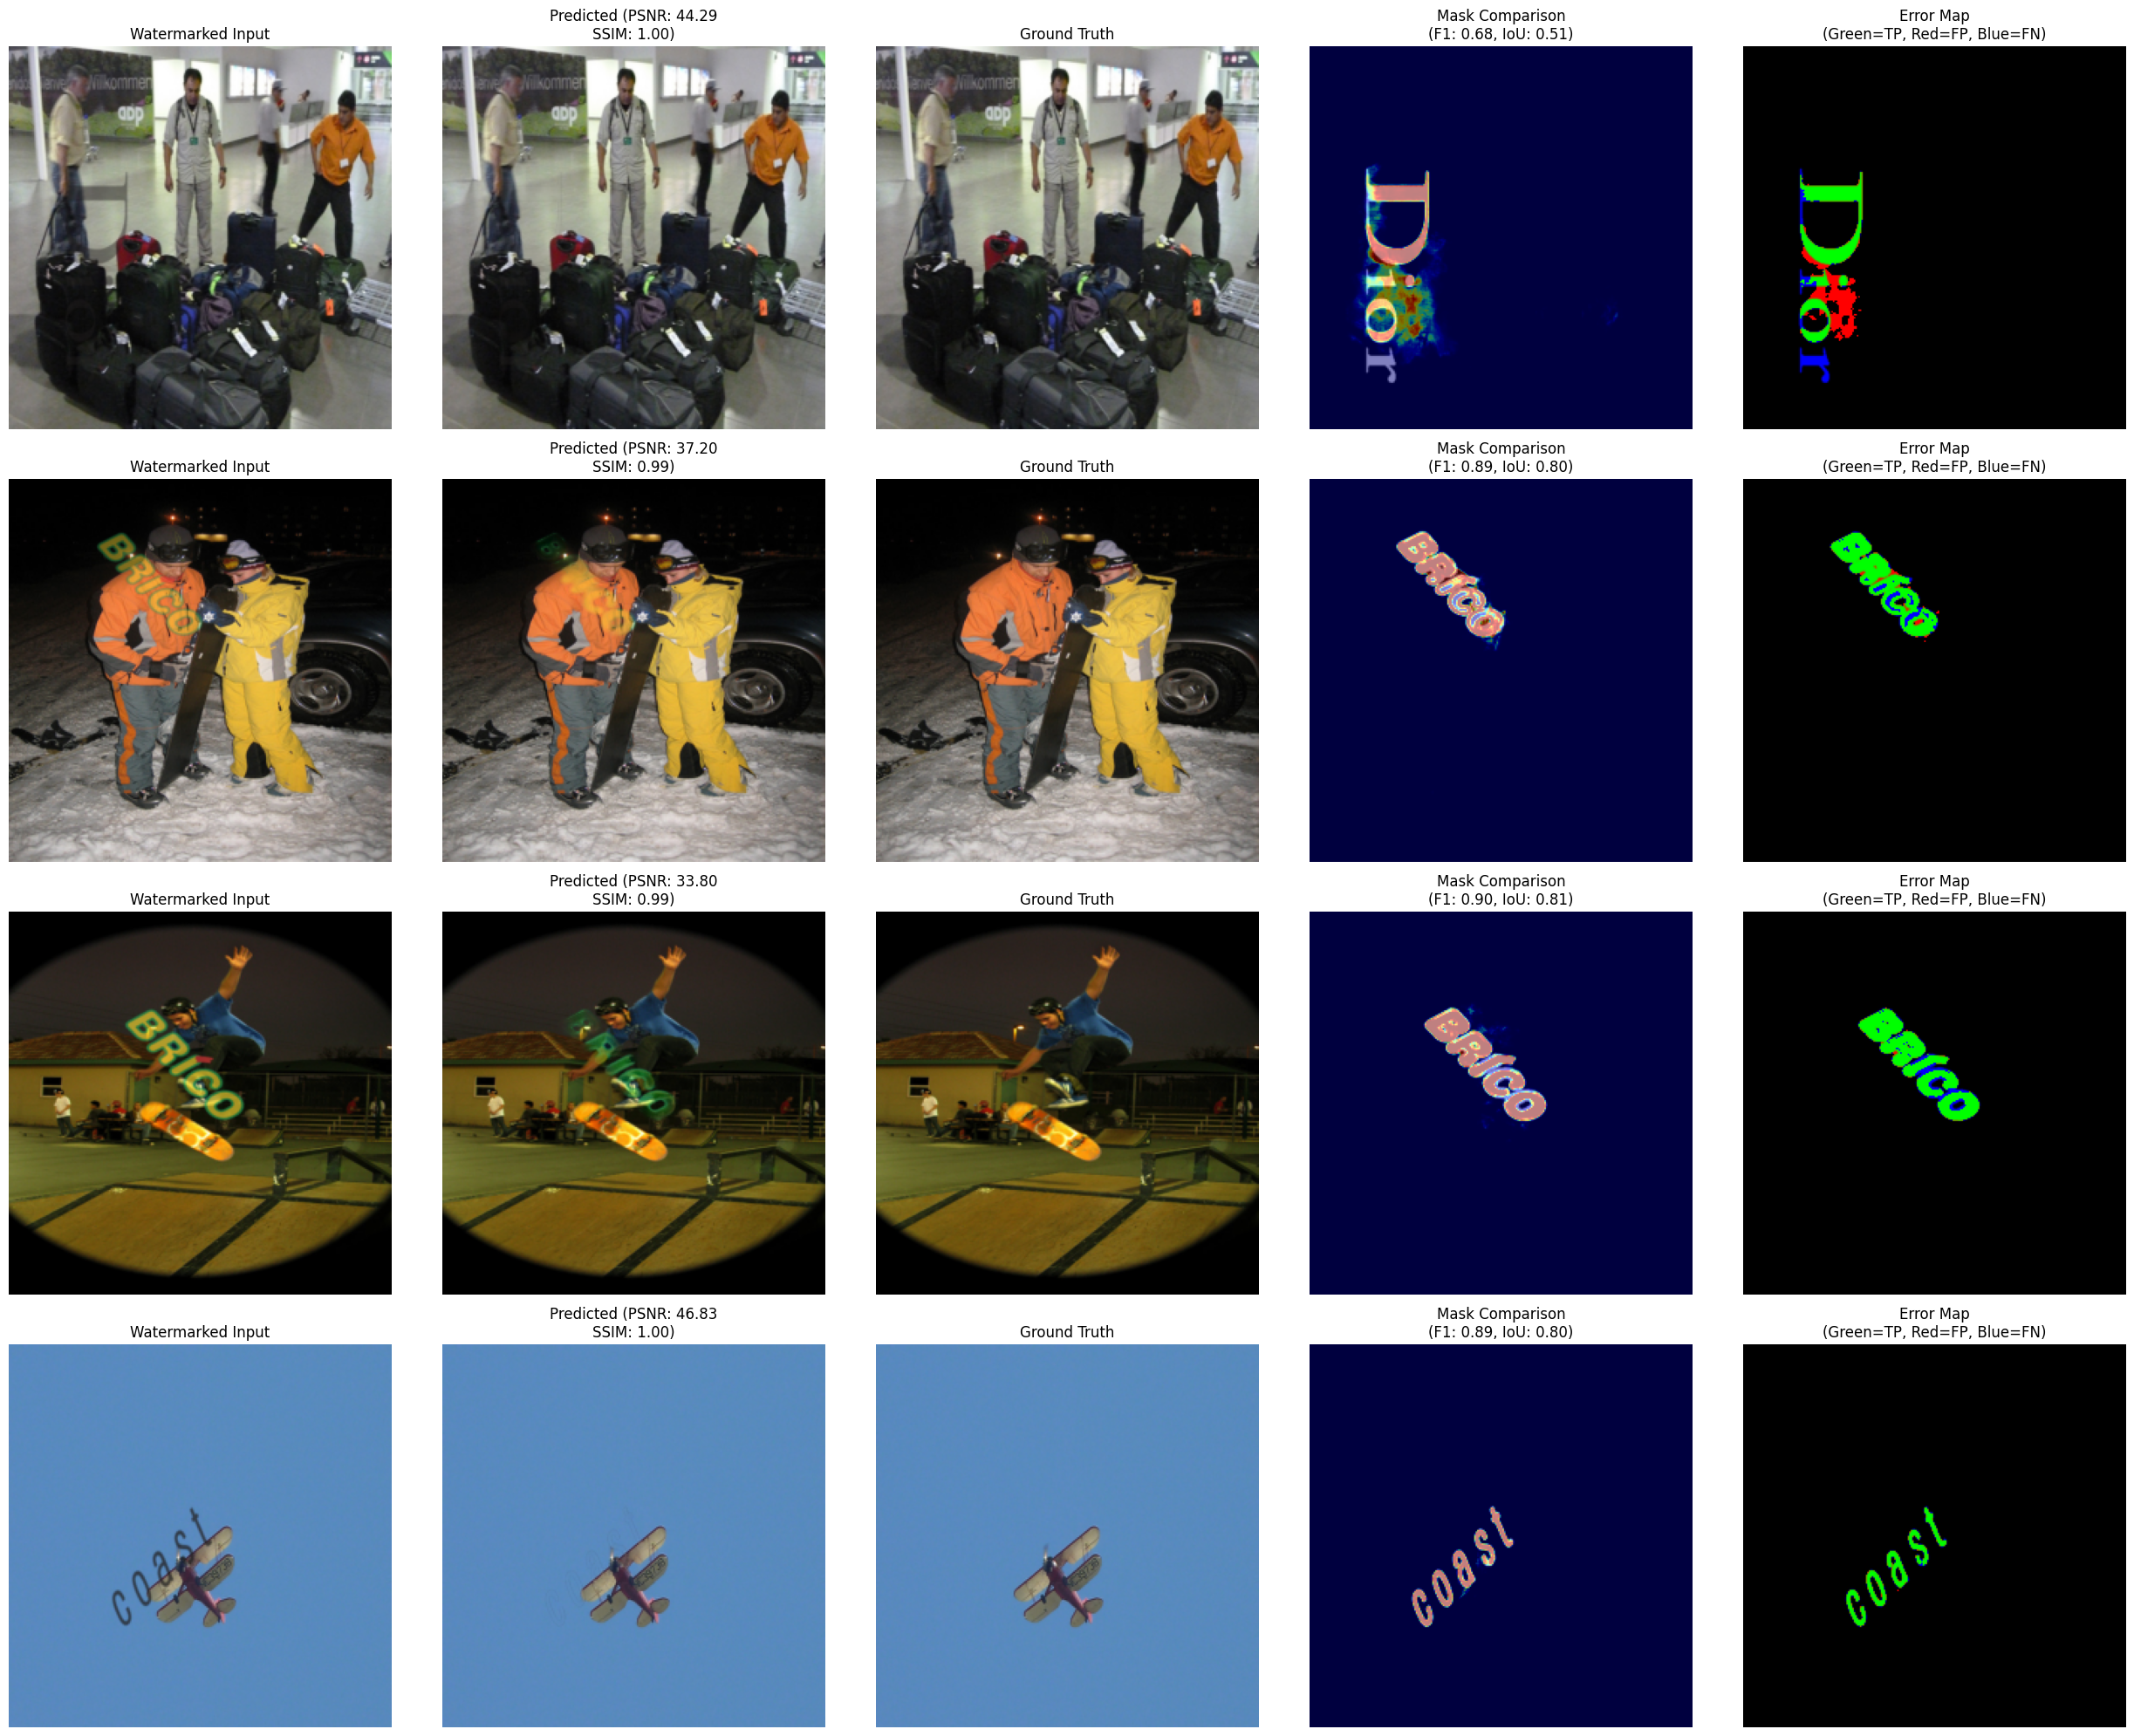

In [19]:
visualize_random_samples(model, val_loader, device, num_samples=4)

In [ ]:
for image_path in image_paths:
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        I_hat, _ = model(image_tensor)
    
    output_image = denormalize(I_hat).squeeze(0).cpu()   
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_dir, f"{filename}")
    
    save_image(output_image, output_path)